In [ ]:
#import ee
#ee.Authenticate()

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
from datetime import datetime

import os
import ipywidgets as widgets

import tkinter as tk
from tkinter import filedialog as fd

import ee
import geemap
ee.Initialize()

In [16]:
# FUNCIONES

# quita los caracteres especiales de un texto enviado
def quitar_caracteres(text):
    text = text.replace('_', ' ')
    text = text.replace('"', '')
    text = text.replace('.', '')
    return text

# convierte las columnas unidad_01 y unidad_03 a entero
propiedad = propiedad.astype({
    'unidad_01':'int',
    'unidad_03':'int'
})

In [4]:
# open file dialog
root = tk.Tk()
root.attributes('-topmost', True)
root.iconify()
file_name = fd.askopenfilename(parent=root, filetypes=[(".shp", ".shp")])
root.destroy()

In [5]:
file_name

'D:/OneDrive - Ingenio Azucarero Guabira S.A/INFORMACION GENERAL/CATASTRO/CATASTRO_2023-04-15.shp'

In [6]:
# leer el .shp seleccionado
data = gpd.read_file(file_name)

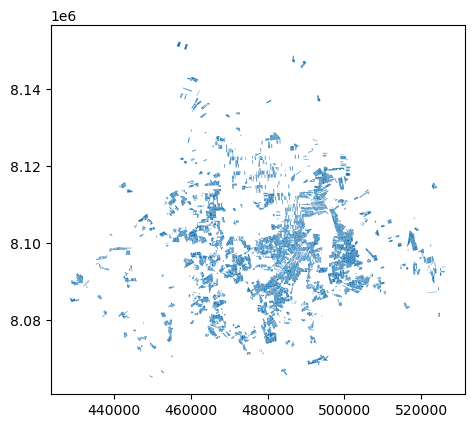

In [7]:
data.plot()
plt.show()

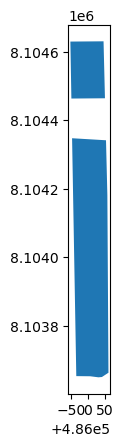

In [14]:
propiedad = data[data['unidad_01']==220]
propiedad.plot()
plt.show()

In [17]:
propiedad.head(3)

,id,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,variedad,fs,textura,financia,soca,cultivo,zona,area,geometry
12766,000019400000L1,1940,PARCELA_FELICIANO--ROJAS_FELICIANO,12061,ROJAS_FELICIANO,L1,UCG_90-20,2015-07-24,F,NaN,7,canha,48,6.75,"POLYGON Z ((485953.944 8104347.444 0.000, 4860..."
12767,000019400000L2,1940,PARCELA_FELICIANO--ROJAS_FELICIANO,12061,ROJAS_FELICIANO,L2,UCG_90-20,2015-07-14,F,NaN,7,canha,48,1.62,"POLYGON Z ((486049.940 8104464.177 0.000, 4859..."


In [20]:
# extraer nombre de propiedad
file_name = str(propiedad.iloc[0]['unidad_01']) + '_' + propiedad.iloc[0]['unidad_02']
file_name

'1940_PARCELA_FELICIANO--ROJAS_FELICIANO'

In [23]:
# se cambia el nombre de tres columnas
propiedad = propiedad.rename(columns={'id':'cod', 'variedad':'var', 'textura':'tex'})
propiedad.head(5)

,cod,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,var,fs,tex,financia,soca,cultivo,zona,area,geometry
12766,000019400000L1,1940,PARCELA_FELICIANO--ROJAS_FELICIANO,12061,ROJAS_FELICIANO,L1,UCG_90-20,2015-07-24,F,NaN,7,canha,48,6.75,"POLYGON Z ((485953.944 8104347.444 0.000, 4860..."
12767,000019400000L2,1940,PARCELA_FELICIANO--ROJAS_FELICIANO,12061,ROJAS_FELICIANO,L2,UCG_90-20,2015-07-14,F,NaN,7,canha,48,1.62,"POLYGON Z ((486049.940 8104464.177 0.000, 4859..."


In [24]:
propiedad

,cod,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,var,fs,tex,financia,soca,cultivo,zona,area,geometry
12766,000019400000L1,1940,PARCELA_FELICIANO--ROJAS_FELICIANO,12061,ROJAS_FELICIANO,L1,UCG_90-20,2015-07-24,F,NaN,7,canha,48,6.75,"POLYGON Z ((485953.944 8104347.444 0.000, 4860..."
12767,000019400000L2,1940,PARCELA_FELICIANO--ROJAS_FELICIANO,12061,ROJAS_FELICIANO,L2,UCG_90-20,2015-07-14,F,NaN,7,canha,48,1.62,"POLYGON Z ((486049.940 8104464.177 0.000, 4859..."


In [277]:
num_columnas = len(propiedad.columns)
num_columnas

15

In [278]:
propiedad['NOM_LOTE'] = propiedad['unidad_05']
propiedad['TEXTURA'] = propiedad['tex']
propiedad['SUPERFICIE'] = propiedad['area']
propiedad['VARIEDAD'] = propiedad['var']
propiedad['FECHA_SIEM'] = propiedad['fs']
propiedad['CORTE'] = propiedad['soca']
propiedad['ESTADO'] = ''
propiedad['RENDIMIENT'] = 0
propiedad['COD_CA'] = propiedad['unidad_03']
propiedad['COD_PROP'] = propiedad['unidad_01']
propiedad['ID'] = propiedad['cod']
propiedad['CUADRANTE'] = 0

In [279]:
propiedad.head(3)

,cod,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,var,fs,tex,financia,...,SUPERFICIE,VARIEDAD,FECHA_SIEM,CORTE,ESTADO,RENDIMIENT,COD_CA,COD_PROP,ID,CUADRANTE
1902,00002200000L1,220,SANTA_BARBARA,2641,CRONENBOLD_AGUILERA_ROBERTO,L1,RENOVACION,NaN,Y,NaN,...,16.40,RENOVACION,NaN,122,,0,2641,220,00002200000L1,0
1903,00002200000L2,220,SANTA_BARBARA,2641,CRONENBOLD_AGUILERA_ROBERTO,L2,RENOVACION,NaN,FA,NaN,...,11.32,RENOVACION,NaN,122,,0,2641,220,00002200000L2,0
1904,00002200000L3,220,SANTA_BARBARA,2641,CRONENBOLD_AGUILERA_ROBERTO,L3,RENOVACION,NaN,FA,NaN,...,14.17,RENOVACION,NaN,122,,0,2641,220,00002200000L3,0


In [280]:
propiedad.columns

Index(['cod', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05',
       'var', 'fs', 'tex', 'financia', 'soca', 'cultivo', 'zona', 'area',
       'geometry', 'NOM_LOTE', 'TEXTURA', 'SUPERFICIE', 'VARIEDAD',
       'FECHA_SIEM', 'CORTE', 'ESTADO', 'RENDIMIENT', 'COD_CA', 'COD_PROP',
       'ID', 'CUADRANTE'],
      dtype='object')

In [281]:
propiedad = propiedad.iloc[:,num_columnas-1:]

In [282]:
propiedad.head(5)

,geometry,NOM_LOTE,TEXTURA,SUPERFICIE,VARIEDAD,FECHA_SIEM,CORTE,ESTADO,RENDIMIENT,COD_CA,COD_PROP,ID,CUADRANTE
1902,"POLYGON Z ((485366.455 8085840.488 0.000, 4850...",L1,Y,16.40,RENOVACION,NaN,122,,0,2641,220,00002200000L1,0
1903,"POLYGON Z ((484875.602 8086192.867 0.000, 4848...",L2,FA,11.32,RENOVACION,NaN,122,,0,2641,220,00002200000L2,0
1904,"POLYGON Z ((485171.974 8086512.199 0.000, 4848...",L3,FA,14.17,RENOVACION,NaN,122,,0,2641,220,00002200000L3,0
11241,"POLYGON Z ((484984.357 8087243.387 0.000, 4850...",L4,FY,11.93,RENOVACION,NaN,122,,0,2641,220,00002200000L4,0
11461,"POLYGON Z ((485415.793 8085724.242 0.000, 4852...",L5,FY,36.21,RENOVACION,NaN,122,,0,2641,220,00002200000L5,0


In [283]:
# dependiendo del año de la fecha de siembra, retorna 'HOJA', 'SOCA' o 'RENOVACION'
def establecer_estado(fecha):
    date = str(fecha)
    try:
        date = datetime.strptime(date, '%Y-%m-%d')
        year = date.year
        if year == 2022:
            return 'HOJA'
        elif year > 2000:
            return 'SOCA'
        else:
            return 'RENOVACION'
    except Exception as ex:
        return 'RENOVACION'

In [284]:
def establecer_formato_fecha(fecha):
    fecha = str(fecha)
    if fecha == 'None':
        return '0'
    else:
        return fecha.replace('-', '')

In [285]:
propiedad['ESTADO'] = propiedad['FECHA_SIEM'].apply(establecer_estado)
propiedad['FECHA_SIEM'] = propiedad['FECHA_SIEM'].apply(establecer_formato_fecha)

In [286]:
propiedad.head()

,geometry,NOM_LOTE,TEXTURA,SUPERFICIE,VARIEDAD,FECHA_SIEM,CORTE,ESTADO,RENDIMIENT,COD_CA,COD_PROP,ID,CUADRANTE
1902,"POLYGON Z ((485366.455 8085840.488 0.000, 4850...",L1,Y,16.40,RENOVACION,nan,122,RENOVACION,0,2641,220,00002200000L1,0
1903,"POLYGON Z ((484875.602 8086192.867 0.000, 4848...",L2,FA,11.32,RENOVACION,nan,122,RENOVACION,0,2641,220,00002200000L2,0
1904,"POLYGON Z ((485171.974 8086512.199 0.000, 4848...",L3,FA,14.17,RENOVACION,nan,122,RENOVACION,0,2641,220,00002200000L3,0
11241,"POLYGON Z ((484984.357 8087243.387 0.000, 4850...",L4,FY,11.93,RENOVACION,nan,122,RENOVACION,0,2641,220,00002200000L4,0
11461,"POLYGON Z ((485415.793 8085724.242 0.000, 4852...",L5,FY,36.21,RENOVACION,nan,122,RENOVACION,0,2641,220,00002200000L5,0


In [287]:
fp_tch = r'D:\OneDrive - Ingenio Azucarero Guabira S.A\APP CAÑERO\PROPIEDADES\DATOS_PARA_GENERAR_GEOJSON\RENDIMIENTO AVANCE 071022.xlsx'

In [288]:
tchs = pd.read_excel(fp_tch)

In [289]:
tchs.head(3)

,COD_AVANCE,CODIGO CAÑERO,INS,NOMBRE CAÑERO,DESSIG,CREA,COMPROMISO GRUPAL,COMPROMISO INDIVIDUAL,HA CANHA POR GRUPO,HA CANHA INDIVIDUAL,TN ENTREGA GRUPAL,TN ENTREGADAS INDIVIDUAL,% ENTREGA GRUPAL,HA COSECHA GRUPAL,HA COSECHA INDIVIDUAL,% COSECHA GRUPAL,RENDIMIENTO 2022,RENDIMIENTO 2021,ESTIMATIVA RENDIMIENTO 2022,OBSERVACIONES
0,131_1,2224,NaN,CRUZ VARGAS WILLY WALDO,NaN,NaN,7067.07,0.00,NaN,NaN,0.00,42.86,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,81_36,41555,81.0,FRANCO GUZMAN CARLA DANIELA,NaN,NaN,7053.98,7053.98,0.0,0.0,7138.06,7138.06,1.011920,0.0,0.0,NaN,NaN,0.000000,59.896088,SIN CATASTRO
2,50_29,15501,50.0,WENDE RIOJA MAURICIO,NaN,NaN,4525.38,4525.38,0.0,0.0,3537.96,3537.96,0.781804,0.0,0.0,NaN,NaN,39.153575,0.000000,SIN CATASTRO


In [291]:
def cargar_tch(cod_ca):
    tch = float(tchs[tchs['CODIGO CAÑERO'] == cod_ca].iloc[:,16])
    try:
        tch_float = float(tch)
        return tch_float
    except:
        return 0

In [292]:
#CONVERTIR LOS TIPOS DE VARIABLE
propiedad = propiedad.astype({
    'RENDIMIENT':'float',
    'COD_CA':'int',
    'COD_PROP':'int'
})

In [293]:
propiedad['RENDIMIENT'] = propiedad['COD_CA'].apply(cargar_tch)
propiedad.head(3)

C:\Users\UTEA\AppData\Local\Temp\ipykernel_18740\1276023081.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tch = float(tchs[tchs['CODIGO CAÑERO'] == cod_ca].iloc[:,16])


,geometry,NOM_LOTE,TEXTURA,SUPERFICIE,VARIEDAD,FECHA_SIEM,CORTE,ESTADO,RENDIMIENT,COD_CA,COD_PROP,ID,CUADRANTE
1902,"POLYGON Z ((485366.455 8085840.488 0.000, 4850...",L1,Y,16.40,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L1,0
1903,"POLYGON Z ((484875.602 8086192.867 0.000, 4848...",L2,FA,11.32,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L2,0
1904,"POLYGON Z ((485171.974 8086512.199 0.000, 4848...",L3,FA,14.17,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L3,0


In [294]:
fp_bloques = r'D:\OneDrive - Ingenio Azucarero Guabira S.A\APP CAÑERO\PROPIEDADES\DATOS_PARA_GENERAR_GEOJSON\BLOQUES.xlsx'

In [295]:
bloques = pd.read_excel(fp_bloques)

In [296]:
bloques.head(3)

,idnax,id,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,variedad,fs,fc,...,riegos_pos,agua_disp,agua_aprov,agua_act,estrato,tipo_cos,resiembra_pct,activo,fk_estacion,inicio_curva
0,276044,00005600000L1.3,560,LA_TUJA_IAG_SA,15284,ROJAS_CORDOVA_ROGELIO_FELIPE,L1.3,UCG9020,44743,44743.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1,276045,00005600000L1.5,560,LA_TUJA_IAG_SA,15284,ROJAS_CORDOVA_ROGELIO_FELIPE,L1.5,UCG9020,44768,44768.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
2,276046,00005600000L2.2,560,LA_TUJA_IAG_SA,15284,ROJAS_CORDOVA_ROGELIO_FELIPE,L2.2,CITTCA8522,44783,44783.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN


In [297]:
def cargar_bloque(cod_prop):
    bloque = bloques[bloques['unidad_01']==cod_prop].head(1).loc[:,'cuadrante']
    try:
        bloque_int = int(bloque)
        return bloque_int
    except:
        return 0

In [298]:
propiedad['CUADRANTE']=propiedad['COD_PROP'].apply(cargar_bloque)
propiedad.head(3)

,geometry,NOM_LOTE,TEXTURA,SUPERFICIE,VARIEDAD,FECHA_SIEM,CORTE,ESTADO,RENDIMIENT,COD_CA,COD_PROP,ID,CUADRANTE
1902,"POLYGON Z ((485366.455 8085840.488 0.000, 4850...",L1,Y,16.40,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L1,0
1903,"POLYGON Z ((484875.602 8086192.867 0.000, 4848...",L2,FA,11.32,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L2,0
1904,"POLYGON Z ((485171.974 8086512.199 0.000, 4848...",L3,FA,14.17,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L3,0


In [299]:
propiedad['ID'] = propiedad.apply(lambda x : '0000' + str(x['COD_PROP']) + '0000' + x['NOM_LOTE'], axis=1)

In [300]:
propiedad.head(3)

,geometry,NOM_LOTE,TEXTURA,SUPERFICIE,VARIEDAD,FECHA_SIEM,CORTE,ESTADO,RENDIMIENT,COD_CA,COD_PROP,ID,CUADRANTE
1902,"POLYGON Z ((485366.455 8085840.488 0.000, 4850...",L1,Y,16.40,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L1,0
1903,"POLYGON Z ((484875.602 8086192.867 0.000, 4848...",L2,FA,11.32,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L2,0
1904,"POLYGON Z ((485171.974 8086512.199 0.000, 4848...",L3,FA,14.17,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L3,0


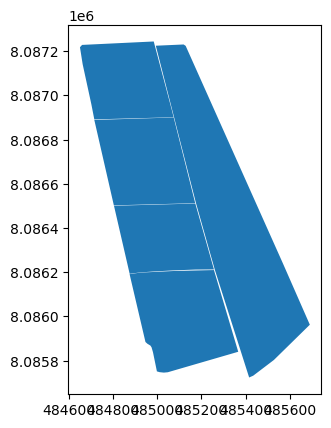

In [301]:
propiedad.plot()
plt.show()

In [302]:
#quitar_caracteres
propiedad['VARIEDAD'] = propiedad['VARIEDAD'].apply(quitar_caracteres)

In [303]:
propiedad

,geometry,NOM_LOTE,TEXTURA,SUPERFICIE,VARIEDAD,FECHA_SIEM,CORTE,ESTADO,RENDIMIENT,COD_CA,COD_PROP,ID,CUADRANTE
1902,"POLYGON Z ((485366.455 8085840.488 0.000, 4850...",L1,Y,16.40,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L1,0
1903,"POLYGON Z ((484875.602 8086192.867 0.000, 4848...",L2,FA,11.32,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L2,0
1904,"POLYGON Z ((485171.974 8086512.199 0.000, 4848...",L3,FA,14.17,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L3,0
11241,"POLYGON Z ((484984.357 8087243.387 0.000, 4850...",L4,FY,11.93,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L4,0
11461,"POLYGON Z ((485415.793 8085724.242 0.000, 4852...",L5,FY,36.21,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L5,0


In [304]:
propiedad.head()

,geometry,NOM_LOTE,TEXTURA,SUPERFICIE,VARIEDAD,FECHA_SIEM,CORTE,ESTADO,RENDIMIENT,COD_CA,COD_PROP,ID,CUADRANTE
1902,"POLYGON Z ((485366.455 8085840.488 0.000, 4850...",L1,Y,16.40,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L1,0
1903,"POLYGON Z ((484875.602 8086192.867 0.000, 4848...",L2,FA,11.32,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L2,0
1904,"POLYGON Z ((485171.974 8086512.199 0.000, 4848...",L3,FA,14.17,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L3,0
11241,"POLYGON Z ((484984.357 8087243.387 0.000, 4850...",L4,FY,11.93,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L4,0
11461,"POLYGON Z ((485415.793 8085724.242 0.000, 4852...",L5,FY,36.21,RENOVACION,nan,122,RENOVACION,66.142049,2641,220,00002200000L5,0


In [305]:
propiedad.crs

<Projected CRS: EPSG:32720>
Name: WGS 84 / UTM zone 20S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 66°W and 60°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Falkland Islands (Malvinas). Paraguay.
- bounds: (-66.0, -80.0, -60.0, 0.0)
Coordinate Operation:
- name: UTM zone 20S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [306]:
propiedad = propiedad.to_crs(epsg=4326)

In [307]:
propiedad.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [308]:
propiedad['SUPERFICIE'].sum()

90.03

In [309]:
file_name + '.geojson'

'220_SANTA_BARBARA.geojson'

In [310]:
#file_name='d'

In [311]:
os.chdir(r"D:\OneDrive - Ingenio Azucarero Guabira S.A\APP CAÑERO\PROPIEDADES\DATOS_PARA_GENERAR_GEOJSON\PROPIEDADES_OFFICIALES")

In [312]:
out_dir = os.path.normpath((os.getcwd() + '/' + file_name + '.geojson' ))

In [313]:
out_dir

'D:\\OneDrive - Ingenio Azucarero Guabira S.A\\APP CAÑERO\\PROPIEDADES\\DATOS_PARA_GENERAR_GEOJSON\\PROPIEDADES_OFFICIALES\\220_SANTA_BARBARA.geojson'

In [315]:
propiedad.to_file(out_dir, driver='GeoJSON')